In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib
import openpyxl
from sklearn.svm import SVR
from xgboost import XGBRegressor
import scienceplots
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 00 General + functions

In [2]:
# INPUT 1/4
model_input = 'Log_periods'
model_target = 'Ratio_var'
x_label = model_input
y_label = "Ratio_var"
title = f"{y_label} vs {x_label}"


# Plot input data
y_label=r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$"
x_label="Periods (s)"
title = ""
file_name = model_target
save_path = "figures_report/" # save in figures_report folder - None if you don't want to save

In [3]:
# Load the pickled DataFrame
df_dataset = pd.read_pickle(f'datasets/working_df.pkl')[[model_input, model_target]]

min_value = df_dataset[model_input].min()
max_value = df_dataset[model_input].max()

df_dataset

Log_periods  Ratio_var
0      -2.000000   0.007216
1      -1.698970   0.007161
2      -1.657577   0.007126
3      -1.602060   0.007053
4      -1.537602   0.006993
..           ...        ...
100     0.903090   0.007087
101     0.929419   0.007057
102     0.954243   0.007052
103     0.977724   0.007054
104     1.000000   0.006938

[105 rows x 2 columns]

In [4]:
# Define features and target
X = df_dataset[[model_input]]  # Features
y = df_dataset[model_target]    # Target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## 0.1 Functions

In [5]:
def hyperparameter_selection(X_train, y_train, model, param_grid, model_name, model_target):
    # Create a pipeline with scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Add scaler step
        ('model', model)
    ])
    
    # Update parameter grid to match pipeline's naming convention
    pipeline_param_grid = {f'model__{key}': value for key, value in param_grid.items()}
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=pipeline_param_grid, cv=10, scoring='neg_mean_squared_error')
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print("Best Parameters:", best_params)
    print("Best Cross-Validated MSE Score:", best_score)
    
    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    
    # Save the model to a .pkl file
    joblib.dump(best_model, f'models/{model_name}_{model_target}.pkl')
    print(f"Model saved as {model_name}_{model_target}.pkl")
    
    # Extract cross-validation results
    cv_results = grid_search.cv_results_
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'hyperparameters': cv_results['params'],
        'mean MSE': cv_results['mean_test_score'],
        'std': cv_results['std_test_score']
    })
    
    # Save the DataFrame to an Excel file
    excel_filename = f'models/{model_name}_{model_target}_results.xlsx'
    results_df.to_excel(excel_filename, index=False)
    print(f"Cross-validation results saved to {excel_filename}")

In [6]:
def plot_actual_prediction(best_model):
    # Scatter plot for the actual data
    plt.scatter(X_test, y_test, label="Testing Data", color="blue", alpha=0.7)

    # Generate predictions across the range of Periods (min to max)
    X_line = np.linspace(min_value, max_value, 500).reshape(-1, 1)
    y_line_pred = best_model.predict(X_line)

    # Plot the line for predictions
    plt.plot(X_line, y_line_pred, label="Model Prediction", color="red", linewidth=2)

    # Add labels, legend, and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [7]:
def plot_hyperparameters_set(model_name, model_target):
    # 1. Load the Excel file
    excel_filename = f'models/{model_name}_{model_target}_results.xlsx'
    results_df = pd.read_excel(excel_filename)

    # 2. Sort the hyperparameters based on the mean MSE in descending order
    sorted_results = results_df.sort_values(by='mean MSE', ascending=False)

    # Step 3: Plot descending the hyperparameters based on the mean MSE
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_results['mean MSE'].values)
    plt.title(f'Hyperparameters Sorted by Mean MSE for {model_name}')
    plt.xlabel('Hyperparameter Set Index')
    plt.ylabel('Negative Mean MSE')
    plt.show()

    # Step 4: Extract the top 10 hyperparameter sets
    top_10 = sorted_results.head(10)

    # Step 5: Print the best model
    print(f"The best hyperparameter's set is:\n {top_10['hyperparameters'].iloc[0]}")

    # Return the top 10 hyperparameter sets with mean test score
    return top_10[['hyperparameters', 'mean MSE', 'std']]

# 01 Random Forest

In [8]:
# INPUT 2/4
# Model
model_name = 'Random_Forest_2'

# INPUT 3/4
mode = 0

# modes
# 0: training the model
# 1: loading the model

In [9]:
# INPUT 4/4
if not mode:
    # Define the model
    rf = RandomForestRegressor(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
        'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
        'max_depth': [None, 10, 20, 30, 50],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    }

    hyperparameter_selection(X_train, y_train, rf, param_grid, model_name, model_target)

C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500}
Best Cross-Validated MSE Score: -2.8941255081955674e-09
Model saved as Random_Forest_2_Ratio_var.pkl
Cross-validation results saved to models/Random_Forest_2_Ratio_var_results.xlsx


In [10]:
# Load the model from the .pkl file
best_model = joblib.load(f'models/{model_name}_{model_target}.pkl')

y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store performance metrics in a DataFrame
performance_df = pd.DataFrame({
    'Model': [model_name],
    'MSE': [mse],
    'R2 Score': [r2]
})

print("Test MSE:", mse)
print("Test R2 Score:", r2)

Test MSE: 2.73636274975869e-09
Test R2 Score: 0.8440806861539394


In [11]:
plot_actual_prediction(best_model)

C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
hyp_df = plot_hyperparameters_set(model_name, model_target)

The best hyperparameter's set is:
 {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500}


In [13]:
# print(f"Top 10 Hyperparameter Sets Based on Mean negative MSE for {model_name}:")
hyp_df

hyperparameters      mean MSE  \
471  {'model__criterion': 'absolute_error', 'model_... -2.894126e-09   
435  {'model__criterion': 'absolute_error', 'model_... -2.894126e-09   
507  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
543  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
579  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
687  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
651  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
615  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
363  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   
399  {'model__criterion': 'absolute_error', 'model_... -2.902791e-09   

              std  
471  1.710550e-09  
435  1.710550e-09  
507  1.713548e-09  
543  1.713548e-09  
579  1.713548e-09  
687  1.713548e-09  
651  1.713548e-09  
615  1.713548e-09  
363  1.713548e-09  
399  1.713548e-09

# 02 SVM

In [14]:
# INPUT 2/4
# Model
model_name = 'SVM_2'

# INPUT 3/4
mode = 0

# modes
# 0: training the model
# 1: loading the model

In [15]:
# INPUT 4/4
if not mode:
    # Define the Supported Vector Machine model
    svr = SVR()

    # Define the parameter grid for RandomForestRegressor
    param_grid = {
        'kernel': ['rbf', 'sigmoid'],  # Different kernel types
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 0.01, 0.001],  # Margin of tolerance
        #'degree': [2, 3, 4, 5]  # Degree for polynomial kernel (only applicable for 'poly' kernel)
    }
    hyperparameter_selection(X_train, y_train, svr, param_grid, model_name, model_target)

Best Parameters: {'model__C': 0.1, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Cross-Validated MSE Score: -1.8056978445874114e-08
Model saved as SVM_2_Ratio_var.pkl
Cross-validation results saved to models/SVM_2_Ratio_var_results.xlsx


In [16]:
# Load the model from the .pkl file
best_model = joblib.load(f'models/{model_name}_{model_target}.pkl')

y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store performance metrics in a DataFrame
performance_df = pd.concat([performance_df, 
pd.DataFrame({
    'Model': [model_name],
    'MSE': [mse],
    'R2 Score': [r2]
})]
, ignore_index=True)

print("Test MSE:", mse)
print("Test R2 Score:", r2)

Test MSE: 1.7556669353292638e-08
Test R2 Score: -0.0003877735979820329


C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


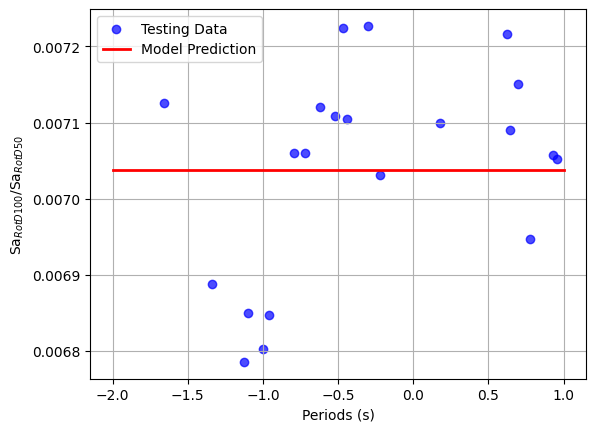

In [17]:
plot_actual_prediction(best_model)

In [18]:
hyp_df = plot_hyperparameters_set(model_name, model_target)

The best hyperparameter's set is:
 {'model__C': 1000, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


In [19]:
# print(f"Top 10 Hyperparameter Sets Based on Mean negative MSE for {model_name}:")
hyp_df

hyperparameters      mean MSE  \
248  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
249  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
250  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
251  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
240  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
241  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
242  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
243  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
244  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   
245  {'model__C': 1000, 'model__epsilon': 0.1, 'mod... -1.805698e-08   

              std  
248  8.701563e-09  
249  8.701563e-09  
250  8.701563e-09  
251  8.701563e-09  
240  8.701563e-09  
241  8.701563e-09  
242  8.701563e-09  
243  8.701563e-09  
244  8.701563e-09  
245  8.701563e-09

# 03 XGBoost

In [20]:
# INPUT 2/4
# Model
model_name = 'XGBoost_2'

# INPUT 3/4
mode = 0

# modes
# 0: training the model
# 1: loading the model

In [21]:
# INPUT 4/4
if not mode:
    # Define the XGBoost Regressor
    xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

    # Define the parameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 200, 500, 1000],  # Number of boosting rounds (trees)
        'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage
        'max_depth': [3, 5, 10],  # Maximum depth of a tree
        'subsample': [0.8],  # Fraction of samples used per tree
        'gamma': [0, 1, 5],  # Minimum loss reduction required to split a node
        'reg_alpha': [0, 10],  # L1 regularization term
        'reg_lambda': [1, 10],  # L2 regularization term
    }

    # Pass the model and parameter grid to the hyperparameter selection function
    hyperparameter_selection(X_train, y_train, xgb_model, param_grid, model_name, model_target)

Best Parameters: {'model__gamma': 0, 'model__learning_rate': 0.3, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__reg_alpha': 0, 'model__reg_lambda': 1, 'model__subsample': 0.8}
Best Cross-Validated MSE Score: -1.8111649092957463e-08
Model saved as XGBoost_2_Ratio_var.pkl
Cross-validation results saved to models/XGBoost_2_Ratio_var_results.xlsx


C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [22]:
# Load the model from the .pkl file
best_model = joblib.load(f'models/{model_name}_{model_target}.pkl')

y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store performance metrics in a DataFrame
performance_df = pd.concat([performance_df, 
pd.DataFrame({
    'Model': [model_name],
    'MSE': [mse],
    'R2 Score': [r2]
})]
, ignore_index=True)

print("Test MSE:", mse)
print("Test R2 Score:", r2)

Test MSE: 1.803799385136068e-08
Test R2 Score: -0.02781388348881686


In [23]:
plot_actual_prediction(best_model)

C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
hyp_df = plot_hyperparameters_set(model_name, model_target)

The best hyperparameter's set is:
 {'model__gamma': 1, 'model__learning_rate': 0.3, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__reg_alpha': 0, 'model__reg_lambda': 1, 'model__subsample': 0.8}


In [25]:
# print(f"Top 10 Hyperparameter Sets Based on Mean negative MSE for {model_name}:")
hyp_df

hyperparameters      mean MSE  \
248  {'model__gamma': 1, 'model__learning_rate': 0.... -1.811165e-08   
408  {'model__gamma': 5, 'model__learning_rate': 0.... -1.811165e-08   
104  {'model__gamma': 0, 'model__learning_rate': 0.... -1.811165e-08   
424  {'model__gamma': 5, 'model__learning_rate': 0.... -1.811165e-08   
120  {'model__gamma': 0, 'model__learning_rate': 0.... -1.811165e-08   
392  {'model__gamma': 5, 'model__learning_rate': 0.... -1.811165e-08   
280  {'model__gamma': 1, 'model__learning_rate': 0.... -1.811165e-08   
136  {'model__gamma': 0, 'model__learning_rate': 0.... -1.811165e-08   
264  {'model__gamma': 1, 'model__learning_rate': 0.... -1.811165e-08   
105  {'model__gamma': 0, 'model__learning_rate': 0.... -1.811840e-08   

              std  
248  1.281887e-08  
408  1.281887e-08  
104  1.281887e-08  
424  1.281887e-08  
120  1.281887e-08  
392  1.281887e-08  
280  1.281887e-08  
136  1.281887e-08  
264  1.281887e-08  
105  1.280778e-08

# Plots

In [26]:
# Load models from each three models from the .pkl file
best_model_rf = joblib.load(f'models/Random_Forest_{model_target}.pkl')
best_model_svm = joblib.load(f'models/SVM_{model_target}.pkl')
best_model_xgb = joblib.load(f'models/XGBoost_{model_target}.pkl')

# Convert from log10 to normal
min_value_lin = 10 ** min_value
max_value_lin = 10 ** max_value
X_test_lin = 10 ** X_test

In [27]:
def science_plot_multiple_models(
    best_model_rf, best_model_svm, best_model_xgb,
    x_label, y_label, title, save_path, file_name
):
    """
    Plots the actual testing data and model predictions from three models 
    (Random Forest, SVM, XGBoost) using the 'science' style.

    Parameters:
    - best_model_rf: The Random Forest model with a `.predict` method.
    - best_model_svm: The SVM model with a `.predict` method.
    - best_model_xgb: The XGBoost model with a `.predict` method.
    - x_label: Label for the x-axis (str), e.g., "Periods (s)".
    - y_label: Label for the y-axis (str), typically a LaTeX-formatted string, e.g., 
               r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$".
    - title: Title of the plot (str). Leave as an empty string for no title.
    - save_path: Optional (str). Directory path to save the plot. If None, the plot is not saved.
    - file_name: Optional (str). Name of the file to be saved (without extension).

    Example Usage:
    science_plot_multiple_models(
        best_model_rf=rf_model,
        best_model_svm=svm_model,
        best_model_xgb=xgb_model,
        x_label="Periods (s)",
        y_label=r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$",
        title="Model Comparison: Random Forest, SVM, XGBoost",
        save_path="figures_report",
        file_name="comparison_plot"
    )
    """
    with plt.style.context(['science']):
        fig, ax = plt.subplots()

        # Scatter plot for the actual test data
        ax.scatter(X_test_lin, y_test, label="Testing Data", color="blue", alpha=0.7)

        # Generate predictions across the range of values for each model
        X_line = np.linspace(min_value, max_value, 500).reshape(-1, 1)
        X_line_lin = 10 ** X_line

        y_line_pred_rf = best_model_rf.predict(X_line)
        y_line_pred_svm = best_model_svm.predict(X_line)
        y_line_pred_xgb = best_model_xgb.predict(X_line)

        # Plot the model prediction curves
        ax.plot(X_line_lin, y_line_pred_rf, label="Random Forest", color="red", linewidth=2, linestyle="--")
        ax.plot(X_line_lin, y_line_pred_svm, label="SVM", color="green", linewidth=2, linestyle="-.")
        ax.plot(X_line_lin, y_line_pred_xgb, label="XGBoost", color="orange", linewidth=2, linestyle=":")

        # Set the x-axis to a logarithmic scale
        ax.set_xscale("log")

        # Add labels, legend, and title
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
        ax.legend(loc="best")
        ax.autoscale(tight=True)

        # Save the plot if save_path is provided
        if save_path:
            # Ensure the save path ends with a slash and construct the file name
            save_path = save_path.rstrip("/") + "/"
            full_file_path = f"{save_path}{file_name}.pdf"
            fig.savefig(full_file_path, format="pdf", dpi=300)
            print(f"Plot saved as PDF at {full_file_path}")

        # Show the plot
        plt.show()



<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_23500\31129024.py:5: SyntaxWarning: invalid escape sequence '\m'
  """


In [28]:
science_plot_multiple_models(
    best_model_rf=best_model_rf,
    best_model_svm=best_model_svm,
    best_model_xgb=best_model_xgb,
    x_label=x_label,
    y_label=y_label,
    title=title,
    save_path=save_path,
    file_name=file_name
)

C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


Plot saved as PDF at figures_report/Ratio_var.pdf


In [29]:
# Sort the DataFrame by 'MSE'
sorted_performance_df = performance_df.sort_values(by='MSE')

# Print the sorted DataFrame
sorted_performance_df

Model           MSE  R2 Score
0  Random_Forest_2  2.736363e-09  0.844081
1            SVM_2  1.755667e-08 -0.000388
2        XGBoost_2  1.803799e-08 -0.027814